# GradCAM implement (VGG19)
PyTorchで準備されている。 ImageNetを学習したVGG19モデルを、  
CIFAR10を識別できるように、ファインチューニングをして、  
GradCAMを用いて、モデルの勾配情報を出力するNotebook。

In [1]:
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
from torch import Tensor
from torch.optim.lr_scheduler import ExponentialLR

from torchvision.datasets import CIFAR10
from  torchvision import transforms
import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt

## ハイパーパラメータ設定

### CPU / GPU 設定

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 各種設定
* バッチサイズ
* エポック数
* CIFAR10データ保存先

In [4]:
batch_size = 64
epochs = 30
cifar_data_root = "./data"

Transformer : 画像データの変換定義

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

CIFAR10データダウンロード

In [6]:
train_data = CIFAR10(root=cifar_data_root, download=True, train=True, transform=transform)
test_data = CIFAR10(root=cifar_data_root, download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Prepare Train / Validation Data Loader
> 学習用 / テスト用のデータローダを作成

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True, 
    num_workers=3
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=3
)

# VGG ファインチューニング

Load pretrained VGG19 Archtecture
> PyTorchで ImageNet学習済みモデルをロード

In [8]:
vgg = torchvision.models.vgg19(pretrained=True)

Replace Output Layer for CIFAR10
> CIFAR10用に、出力層の付け替え

In [9]:
vgg_ftrs = vgg.classifier[6].in_features
vgg.classifier[6] = torch.nn.Linear(vgg_ftrs, 10)

In [10]:
# model = CNNModel().to(device)
model = vgg.to(device)

Define Loss function / Optimizer
> 損失関数と 最適化関数の定義

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2
)

Define Learning Rate Schedular
> 学習率のスケジューラ設定

In [12]:
schedular = ExponentialLR(optimizer, gamma=0.95)

# 学習

In [13]:
epochs = 10
for epoch in range(epochs):
    
    epoch_loss = 0
    correct = 0
    total = 0
    
    model.train()
    for i, samples in enumerate(train_loader):
        data, labels = samples
        
        data  = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        
        predicted = outputs.max(1,  keepdim=True)[1]

        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        total += labels.size(0)
        
        loss.backward()
        optimizer.step()
    # schedular.step()


    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
      for i, (data, labels) in enumerate(test_loader):

        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        _, predicted = outputs.max(1, keepdim=True)
        test_correct += predicted.eq(labels.view_as(predicted)).sum().item()
        test_total += labels.size(0)

    test_accuracy = test_correct / test_total

    print("{}epoch:　　　　Loss {},　　　　Accuracy {},    Test Accuracy {}".format(
        (epoch+1),
        epoch_loss / len(train_loader),
        correct / total,
        test_accuracy
    ))
print("==== Finish Training ====")

1epoch:　　　　Loss 0.7544081092566786,　　　　Accuracy 0.74234,    Test Accuracy 0.7646
2epoch:　　　　Loss 0.429035379930073,　　　　Accuracy 0.85436,    Test Accuracy 0.8351
3epoch:　　　　Loss 0.3123513273799511,　　　　Accuracy 0.89366,    Test Accuracy 0.8637
4epoch:　　　　Loss 0.23102910902417834,　　　　Accuracy 0.9206,    Test Accuracy 0.8282
5epoch:　　　　Loss 0.17230755197660774,　　　　Accuracy 0.9412,    Test Accuracy 0.8684
6epoch:　　　　Loss 0.12223151921297011,　　　　Accuracy 0.95878,    Test Accuracy 0.8772
7epoch:　　　　Loss 0.08872115049484994,　　　　Accuracy 0.97094,    Test Accuracy 0.8768
8epoch:　　　　Loss 0.067385449664622,　　　　Accuracy 0.97756,    Test Accuracy 0.8404
9epoch:　　　　Loss 0.0522747009290237,　　　　Accuracy 0.98352,    Test Accuracy 0.8845
10epoch:　　　　Loss 0.038933040785065515,　　　　Accuracy 0.9875,    Test Accuracy 0.8874
==== Finish Training ====


# GradCAM

In [37]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## GradCamに、1枚の画像を識別させる
> GradCamに、1枚の画像を識別させる

In [53]:
# test_dataの1つを抽出
data, label = test_data[1]
input_data = data.view(1, data.shape[0], data.shape[1], data.shape[2]).to(device)

**Get Prediction output**
> モデルの出力を取得

In [39]:
output = nn.Softmax(dim=1)(model(input_data))
confidence, predicted = torch.max(output.data, 1)

print(
    "Output: {} \n Confidence: {} \n Predicted: {} \n Answer: {}".format(output, confidence, predicted, label)
)

Output: tensor([[1.9656e-05, 2.8250e-05, 9.5156e-07, 9.7462e-08, 4.3462e-08, 3.9018e-08,
         6.2908e-08, 5.6937e-08, 9.9995e-01, 1.2998e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>) 
 Confidence: tensor([0.9999], device='cuda:0') 
 Predicted: tensor([8], device='cuda:0') 
 Answer: 8


## Define the GradCAM
> GradCAMの定義

In [40]:
class _BaseWrapper(object):
  def __init__(self, model):
    super(_BaseWrapper, self).__init__()
    self.device = next(model.parameters()).device
    self.model = model
    self.handlers = []

  def _encode_one_hot(self, ids):
    one_hot = torch.zeros_like(self.logits).to(self.device)
    one_hot.scatter_(1, ids, 1.0)
    return one_hot

  def forward(self, image):
    self.image_shape = image.shape[2:]
    self.logits = self.model(image)
    self.probs = F.softmax(self.logits, dim=1)
    return self.probs.sort(dim=1, descending=True)

  def backward(self, ids):
    one_hot = self._encode_one_hot(ids)
    self.model.zero_grad()
    self.logits.backward(gradient=one_hot, retain_graph=True)

  def generate(self):
    raise NotImplementedError


class GradCAM(_BaseWrapper):
  def __init__(self, model, candidate_layers=None):
    super(GradCAM, self).__init__(model)
    self.fmap_pool = {}
    self.grad_pool = {}
    self.candidate_layers = candidate_layers

    def _save_fmaps(key):
      def forward_hook(module, input, output):
        self.fmap_pool[key] = output.detach()
      return forward_hook

    def _save_grads(key):
      def backward_hook(module, grad_in, grad_out):
        self.grad_pool[key] = grad_out[0].detach()
      return backward_hook

    for name, module in self.model.named_modules():
      """
      ここのfor文で、self.modelの各層の出力を取得できるように、hookを定義
      """
      if self.candidate_layers is None or name in self.candidate_layers:
        self.handlers.append(module.register_forward_hook(_save_fmaps(name)))
        self.handlers.append(module.register_backward_hook(_save_grads(name)))


  def _find(self, pool, target_layer):
    """
    Return a map of a specific layer
      pool: map of output layer (fmap_pool or grad_pool)
      target_layer: name of layer in self.model
    """

    if target_layer in pool.keys():
      return pool[target_layer]
    else:
      raise ValueError("Invalid layer name: {}".format(target_layer))


  def generate(self, target_layer):
    
    fmaps = self._find(self.fmap_pool, target_layer)
    gradients = self._find(self.grad_pool, target_layer)
    weights = F.adaptive_avg_pool2d(gradients, 1)

    gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
    gcam = F.relu(gcam)
    gcam = F.interpolate(
        gcam, self.image_shape, mode='bilinear', align_corners=False
    )

    B, C, H, W = gcam.shape

    # おそらく正規化
    gcam = gcam.view(B, -1)
    gcam -= gcam.min(dim=1, keepdim=True)[0]
    gcam /= gcam.max(dim=1, keepdim=True)[0]
    gcam = gcam.view(B, C, H, W)

    return gcam

In [52]:
def out_gradcam(gcam, raw_image, paper_cmap=False):
  """
  GradCAMの出力をHeatMapに変換 + 元画像にマッピング
  """
  gcam = gcam.cpu().numpy()
  cmap = cm.jet(gcam)[...,:3] * 255.0

  if paper_cmap:
    alpha = gcam[..., None]
    gcam = alpha * cmap + (1 - alpha) * raw_image
  else:
    gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2

  return np.uint8(gcam)

### Forward to GradCAM
> モデルから、勾配を取得

In [42]:
gcam = GradCAM(model=model)

In [43]:
_ = gcam.forward(input_data)

In [44]:
# single_predicted: 1枚の画像なので、次元を1つ追加
single_predicted = predicted.view(1, predicted.shape[0]).to(device)
gcam.backward(ids=single_predicted)

In [45]:
regions = gcam.generate("features.33")

# tensor を、numpy の画像配列に変換
raw_image = input_data[0].to('cpu').detach().numpy().copy()
raw_image = raw_image.transpose((1, 2, 0))
raw_image = ((raw_image * 0.5) + 0.5) * 255.0
raw_image = raw_image.astype(np.uint8)

## Grad CAM 出力

In [46]:
output = out_gradcam(
    gcam=regions[0, 0],
    raw_image=raw_image
)

### Raw Image

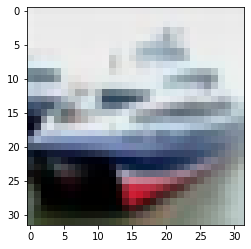

In [50]:
plt.imshow(raw_image)

### GradCAM Output

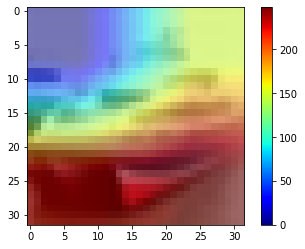

In [51]:
plt.imshow(output, cmap="jet")
plt.colorbar()